In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import json
from datetime import date, timedelta
import math
np.random.seed(seed=42)
# plt.rcParams['text.usetex'] = True
# plt.rcParams["font.family"] = "Times New Roman"
# sns.set_style("whitegrid", rc={'font.family': 'Times New Roman', 'font.size': 16})
plt.rc('legend',fontsize=16)
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 14, 'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14})
sns.set_style("whitegrid", rc={'font.size': 16})

from constants import LOCATION_CHOOSEN, LOCATION_CHOOSEN_2, OUTPUT_DIR, DATA_CACHE_DIR, OPTIMAL_VALUES_FILE, STRINGENCY_BASED_GDP

In [2]:
data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel("owid-covid-data.xlsx")
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

In [3]:
start_date = date(2020, 5, 1)
end_date = date(2022, 11, 1)
# end_date = date(2023, 7, 1)
delta = timedelta(days=1)

worldometers_dates = []
worldometers_total_cases = []
worldometers_total_recovered = []
worldometers_active_cases = []

while start_date <= end_date:
    date_str = start_date.strftime("%Y%m%d")
    data_path_worldometer = os.path.join(DATA_CACHE_DIR, "worldometer", date_str + ".csv")
    if os.path.exists(data_path_worldometer):
        worldometer_df = pd.read_csv(data_path_worldometer)
        worldometer_df.columns = ['country' if col.startswith('Country') else col for col in worldometer_df.columns]
        worldometer_df.columns = worldometer_df.columns.str.lower().str.replace(' ', '')
        date_data = ""
        total_cases = 0
        total_recovered = 0
        worldometer_df_specified_location = worldometer_df.loc[(worldometer_df["country"].str.lower() == LOCATION_CHOOSEN_2.lower())]
        date_data = date_str[:4] + "-" + date_str[4:6] + "-" + date_str[6:]
        total_cases = 0.0 if math.isnan(worldometer_df_specified_location["totalcases"].item()) else worldometer_df_specified_location["totalcases"].item()
        active_cases = 0.0 if math.isnan(worldometer_df_specified_location["activecases"].item()) else worldometer_df_specified_location["activecases"].item()
        total_recovered = 0.0 if math.isnan(worldometer_df_specified_location["totalrecovered"].item()) else worldometer_df_specified_location["totalrecovered"].item()
        print(date_data, total_cases, total_recovered, type(total_recovered), math.isnan(total_recovered))
        worldometers_dates.append(date_data)
        worldometers_total_cases.append(total_cases)
        worldometers_total_recovered.append(total_recovered)
        worldometers_active_cases.append(active_cases)
    else:
        print(data_path_worldometer, "DOES NOT EXIST -- COLLECT DATA MANUALLY")
    start_date += delta

2020-05-01 35043 9068.0 <class 'float'> False
2020-05-02 37257 10007.0 <class 'float'> False
2020-05-03 42505 11775.0 <class 'float'> False
2020-05-04 42670 11782.0 <class 'float'> False
2020-05-05 49400 14142.0 <class 'float'> False
2020-05-06 52987 15331.0 <class 'float'> False
2020-05-07 53045 15331.0 <class 'float'> False
2020-05-08 56516 16867.0 <class 'float'> False
2020-05-09 62808 19301.0 <class 'float'> False
2020-05-10 62939 19358.0 <class 'float'> False
2020-05-11 70768 22549.0 <class 'float'> False
2020-05-12 74243 24420.0 <class 'float'> False
2020-05-13 78055 26400.0 <class 'float'> False
2020-05-14 81990 27969.0 <class 'float'> False
2020-05-15 82103 27977.0 <class 'float'> False
2020-05-16 90615 34220.0 <class 'float'> False
2020-05-17 95648 36794.0 <class 'float'> False
2020-05-18 95698 36795.0 <class 'float'> False
2020-05-19 101261 39233.0 <class 'float'> False
2020-05-20 106475 42309.0 <class 'float'> False
2020-05-21 118226 48553.0 <class 'float'> False
2020-05-22 

2020-10-21 7705158 6871898.0 <class 'float'> False
2020-10-22 7708947 6874518.0 <class 'float'> False
2020-10-23 7763067 6948497.0 <class 'float'> False
2020-10-24 7814682 7016046.0 <class 'float'> False
2020-10-25 7866740 7078123.0 <class 'float'> False
2020-10-26 7909959 7137228.0 <class 'float'> False
2020-10-27 7946429 7201070.0 <class 'float'> False
2020-10-28 7988853 7257194.0 <class 'float'> False
2020-10-29 8041051 7315989.0 <class 'float'> False
2020-10-30 8088851 7373375.0 <class 'float'> False
2020-10-31 8137119 7432829.0 <class 'float'> False
2020-11-01 8184082 7491513.0 <class 'float'> False
2020-11-02 8229322 7544798.0 <class 'float'> False
2020-11-03 8267623 7603121.0 <class 'float'> False
2020-11-04 8313876 7656478.0 <class 'float'> False
2020-11-05 8364086 7711809.0 <class 'float'> False
2020-11-06 8411724 7765966.0 <class 'float'> False
2020-11-07 8462080 7819886.0 <class 'float'> False
2020-11-08 8507754 7868968.0 <class 'float'> False
2020-11-09 8553864 7917373.0 <c

2021-04-15 14074564 12426146.0 <class 'float'> False
2021-04-16 14291917 12547866 <class 'int'> False
2021-04-17 14526609 12671220 <class 'int'> False
2021-04-18 14788109 12809643 <class 'int'> False
2021-04-19 15061919 12953821 <class 'int'> False
2021-04-20 15321089 13108582 <class 'int'> False
2021-04-21 15609004 13269863 <class 'int'> False
2021-04-22 15930965 13454880 <class 'int'> False
2021-04-23 16378571 13692182 <class 'int'> False
2021-04-24 16951621 14077870 <class 'int'> False
2021-04-25 17304308 14292791 <class 'int'> False
2021-04-26 17313163 14304382 <class 'int'> False
2021-04-27 17636307 14556209 <class 'int'> False
2021-04-28 17997267 14817371 <class 'int'> False
2021-04-29 18376524 15086878 <class 'int'> False
2021-04-30 18762976 15384418 <class 'int'> False
2021-05-01 19164969 15684406 <class 'int'> False
2021-05-02 19557457 15992271 <class 'int'> False
2021-05-03 19925604 16293003 <class 'int'> False
2021-05-04 20282833 16613292 <class 'int'> False
2021-05-05 20665

2021-10-01 33766707 33043144.0 <class 'float'> False
2021-10-02 33791061 33068599.0 <class 'float'> False
2021-10-03 33816980 33094529.0 <class 'float'> False
2021-10-04 33834702 33121247.0 <class 'float'> False
2021-10-05 33853048 33150886.0 <class 'float'> False
2021-10-06 33871881 33175656.0 <class 'float'> False
2021-10-07 33894312 33200258.0 <class 'float'> False
2021-10-08 33915569 33225221.0 <class 'float'> False
2021-10-09 33935309 33248291.0 <class 'float'> False
2021-10-10 33953475 33271915.0 <class 'float'> False
2021-10-11 33971293 33285879.0 <class 'float'> False
2021-10-12 33985920 33320057.0 <class 'float'> False
2021-10-13 34001743 33342901.0 <class 'float'> False
2021-10-14 34020730 33362709.0 <class 'float'> False
2021-10-15 34037592 33382100.0 <class 'float'> False
2021-10-16 34052687 33392353.0 <class 'float'> False
2021-10-17 34067719 33419749.0 <class 'float'> False
2021-10-18 34081315 33439331.0 <class 'float'> False
2021-10-19 34094373 33458801.0 <class 'float'>

2022-03-17 43001477 42454546.0 <class 'float'> False
2022-03-18 43004005 42458543.0 <class 'float'> False
2022-03-19 43006080 42461926.0 <class 'float'> False
2022-03-20 43007841 42465122.0 <class 'float'> False
2022-03-21 43009390 42467774.0 <class 'float'> False
2022-03-22 43010971 42470515.0 <class 'float'> False
2022-03-23 43012749 42473057.0 <class 'float'> False
2022-03-24 43014687 42475588.0 <class 'float'> False
2022-03-25 43016372 42478087.0 <class 'float'> False
2022-03-26 43018032 42480436.0 <class 'float'> False
2022-03-27 43019453 42482262.0 <class 'float'> False
2022-03-28 43020723 42483829.0 <class 'float'> False
2022-03-29 43021982 42485534.0 <class 'float'> False
2022-03-30 43023215 42487410.0 <class 'float'> False
2022-03-31 43024440 42489004.0 <class 'float'> False
2022-04-01 43025775 42490922.0 <class 'float'> False
2022-04-02 43027035 42492326.0 <class 'float'> False
2022-04-03 43028131 42493773.0 <class 'float'> False
2022-04-04 43029044 42495089.0 <class 'float'>

2022-10-30 44652266 44104933.0 <class 'float'> False
2022-10-31 44653592 44106656.0 <class 'float'> False
2022-11-01 44654638 44107943.0 <class 'float'> False


In [4]:
worldometer_df = pd.DataFrame({"date": worldometers_dates, "total_cases_worldometer": worldometers_total_cases, "total_recovered_worldometer": worldometers_total_recovered, "active_cases_worldometer": worldometers_active_cases})
result = pd.merge(df, worldometer_df, on="date")
df = result

df['date'] = pd.to_datetime(df['date'])

In [5]:
df

,date,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized,gdp_normalized_modelled,total_cases_worldometer,total_recovered_worldometer,active_cases_worldometer
0,2020-05-01,96.30,35043.0,1147.0,0.000000e+00,1.417173e+09,7668.0,83.905433,88.264410,35043,9068.0,24821.0
1,2020-05-02,96.30,37336.0,1218.0,0.000000e+00,1.417173e+09,7668.0,84.041307,88.264410,37257,10007.0,26027.0
2,2020-05-03,96.30,39980.0,1301.0,0.000000e+00,1.417173e+09,7668.0,84.177181,88.264410,42505,11775.0,29339.0
3,2020-05-04,81.94,42533.0,1373.0,0.000000e+00,1.417173e+09,7668.0,84.313055,94.904432,42670,11782.0,29493.0
4,2020-05-05,81.94,46433.0,1568.0,0.000000e+00,1.417173e+09,7668.0,84.448930,94.904432,49400,14142.0,33565.0
...,...,...,...,...,...,...,...,...,...,...,...,...
910,2022-10-28,31.48,44649088.0,528999.0,2.196044e+09,1.417173e+09,950032740.0,99.893668,99.063148,44649088,44100691.0,19398.0
911,2022-10-29,31.48,44650662.0,529008.0,2.196215e+09,1.417173e+09,950066782.0,99.898210,99.063148,44650714,44102852.0,18854.0
912,2022-10-30,31.48,44652266.0,529016.0,2.196336e+09,1.417173e+09,950090439.0,99.902753,99.063148,44652266,44104933.0,18317.0
913,2022-10-31,31.48,44653592.0,529024.0,2.196409e+09,1.417173e+09,950104356.5,99.907295,99.063148,44653592,44106656.0,17912.0


In [6]:
# deaths are considered recovered: https://www.kaggle.com/code/lisphilar/covid-19-data-with-sir-model/notebook?scriptVersionId=28560520
# https://lisphilar.github.io/covid19-sir/02_data_engineering.html#1.-Data-cleaning

# df['N'] = df['population']
# df['S'] = df['population'] - df['total_cases_worldometer'] - df['people_fully_vaccinated']
# df['I'] = df['total_cases_worldometer'] - df['total_recovered_worldometer'] - df['total_deaths']
# df['R'] = df['total_recovered_worldometer'] + df['people_fully_vaccinated'] + df['total_deaths']

# without deaths model
df['N'] = df['population']
df['S'] = df['population'] - df['total_cases_worldometer'] - df['people_fully_vaccinated'] - df['total_recovered_worldometer']
df['I'] = df['total_cases_worldometer'] - df['total_recovered_worldometer']
df['R'] = df['total_recovered_worldometer'] + df['people_fully_vaccinated']

2313.0


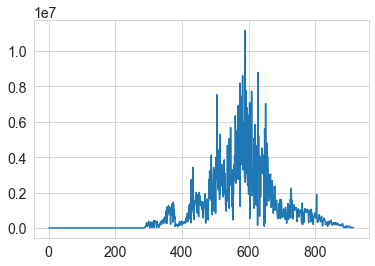

In [7]:
plt.plot( df['people_fully_vaccinated'].diff())
print(min(df['people_fully_vaccinated'].diff()[290:]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


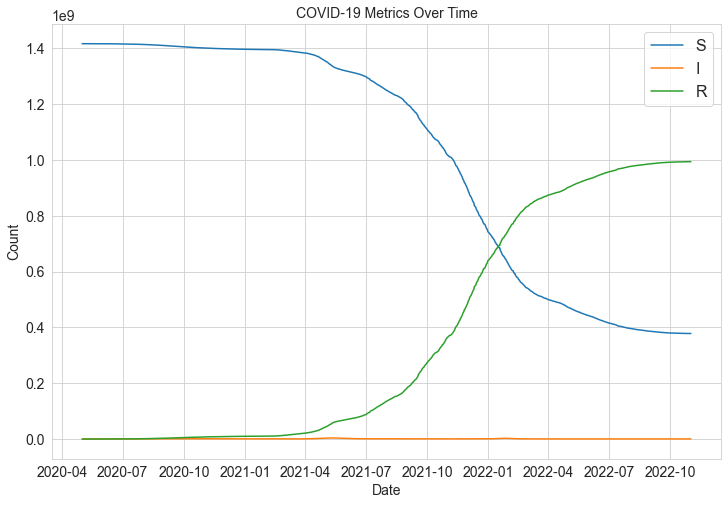

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S'], label='S')
plt.plot(df['date'], df['I'], label='I')
plt.plot(df['date'], df['R'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".eps"))
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


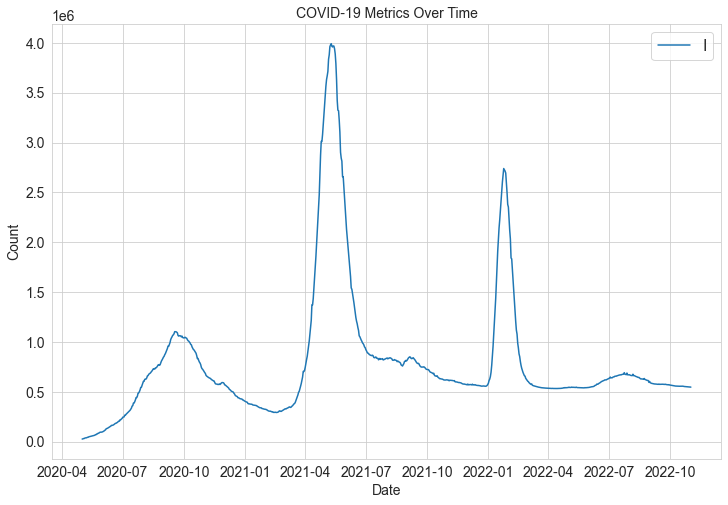

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['I'], label='I')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "infected_over_time_" + LOCATION_CHOOSEN + ".eps"))
plt.show()

## SIR Model

In [10]:
# def compute_cost(data, predictions):
#     # mse
#     return np.square(data - predictions).mean()

# def compute_cost(data, predictions):
#     # mae
#     return np.abs(data - predictions).mean()

# def compute_cost(data, predictions):
#     # Relative Root Mean Squared Error
#     residual = data - predictions
#     root_mean_squared_error = np.sqrt(np.mean(np.square(residual)))
#     mean_data = np.mean(data)
#     return root_mean_squared_error / mean_data

def compute_cost(data, predictions, delta=1.0):
    # Huber loss
    residual = np.abs(data - predictions)
    condition = residual < delta
    squared_loss = 0.5 * np.square(residual)
    linear_loss = delta * (residual - 0.5 * delta)
    return np.where(condition, squared_loss, linear_loss).mean()

In [11]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) +  compute_cost(df['R'], R)
    return cost

In [12]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item() + 1, df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.4, 1/15 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


optimal_beta: 0.04208479828695971 optimal_gamma: 0.02388356686032017
optimal_beta/optimal_gamma: 1.7620817917644795


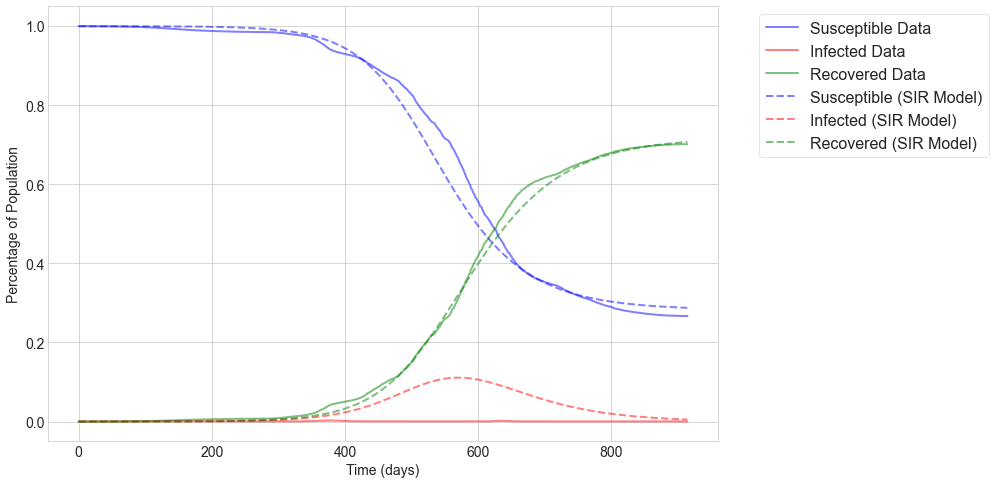

cost: 85051490.53250012


In [13]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma))
S, I, R = ret.T

plt.figure(figsize=(12, 8))
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (SIR Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (SIR Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (SIR Model)')

plt.xlabel('Time (days)')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

SIR_cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost: {SIR_cost}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


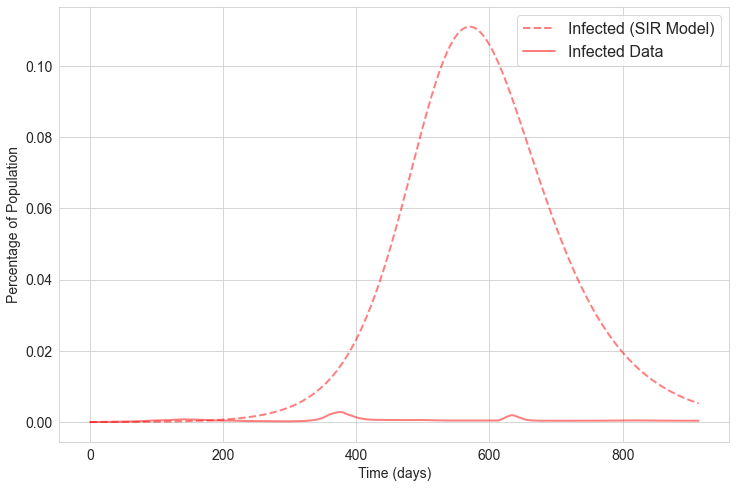

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (SIR Model)')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.xlabel('Time (days)')
plt.ylabel('Percentage of Population')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_infections_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

In [15]:
r0 = optimal_beta/optimal_gamma

df["S_modelled"] = S
df["I_modelled"] = I
df["R_modelled"] = R
df["r_eff_modelled"] = r0 * df["S_modelled"]/N
df["r_eff_actual"] = r0 * df["S"]/df["N"]

## SIR Model with Lockdown

In [16]:
def deriv(y, t, N, beta, gamma, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N, lockdown):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, lockdown))
    return result

def objective_function(params, y0, t, N, lockdown):
    predictions = integrate_system(params, y0, t, N, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [17]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


optimal_beta: 0.4013340889432941 optimal_gamma: 0.09017476605499258
optimal_beta/optimal_gamma: 4.450625230328213


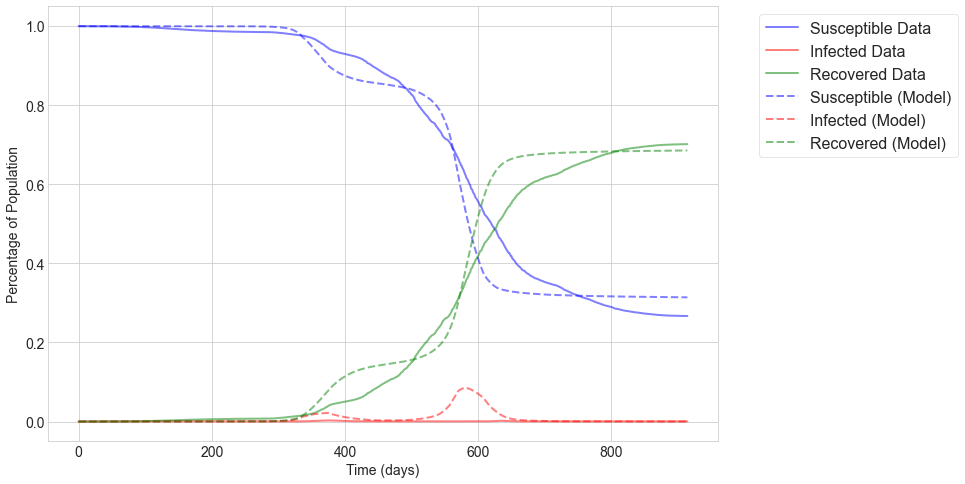

cost: 98438821.45587364


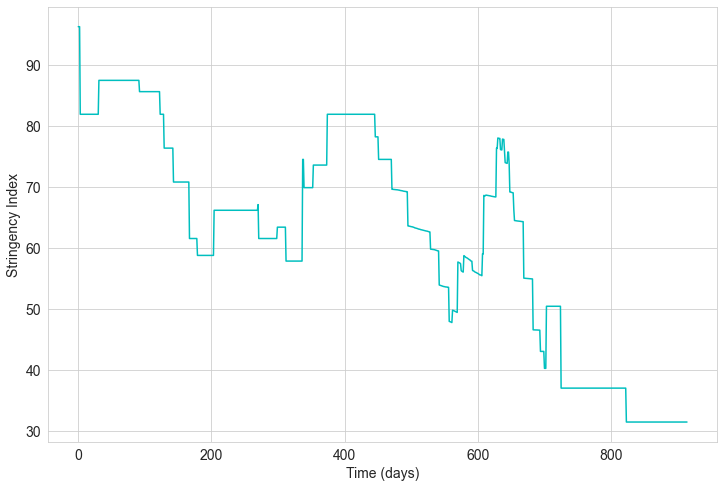

In [18]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
lockdown = list(df['stringency_index'].values / 100)
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N, lockdown),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, lockdown))
S, I, R = ret.T

plt.figure(figsize=(12, 8))
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time (days)')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_with_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(t, df['stringency_index'], 'c')
plt.xlabel('Time (days)')
plt.ylabel('Stringency Index')
plt.grid(True)

SIR_with_lockdown_cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost: {SIR_with_lockdown_cost}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


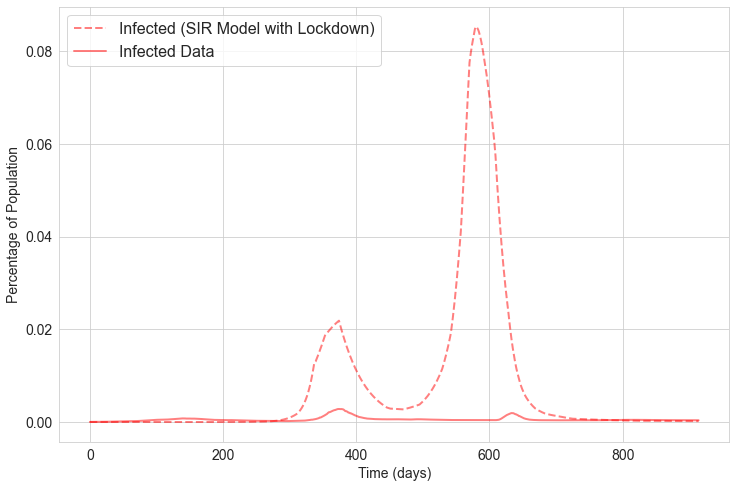

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (SIR Model with Lockdown)')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.xlabel('Time (days)')
plt.ylabel('Percentage of Population')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_with_lockdown_infections_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

In [20]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_with_lockdown"] = S
df["I_modelled_with_lockdown"] = I
df["R_modelled_with_lockdown"] = R
df["r_eff_modelled_with_lockdown"] = r0 * df["S_modelled_with_lockdown"]/N
df["r_eff_actual_with_lockdown"] = r0 * df["S"]/df["N"]

## SIRV Model Lockdown

In [21]:
def deriv(y, t, N, beta, gamma, nu, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N - nu * S
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I + nu * S
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N, lockdown):
    beta, gamma, nu = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, nu, lockdown))
    return result

def objective_function(params, y0, t, N, lockdown):
    predictions = integrate_system(params, y0, t, N, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [22]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
# initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.2, 1./10, 0.0001
# initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.2, 1./10, 0.000001
initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.2, 1./10, 0.000001
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


optimal_beta: 0.40897034072952304 optimal_gamma: 0.09196829370123338 optimal_nu: 2.9044029843851936e-05
optimal_beta/optimal_gamma: 4.446862329077204


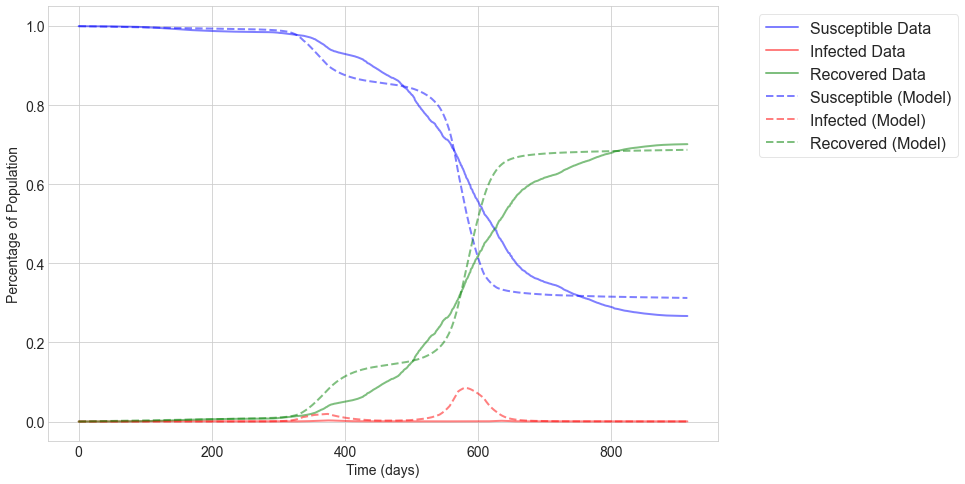

cost: 94636860.38436058


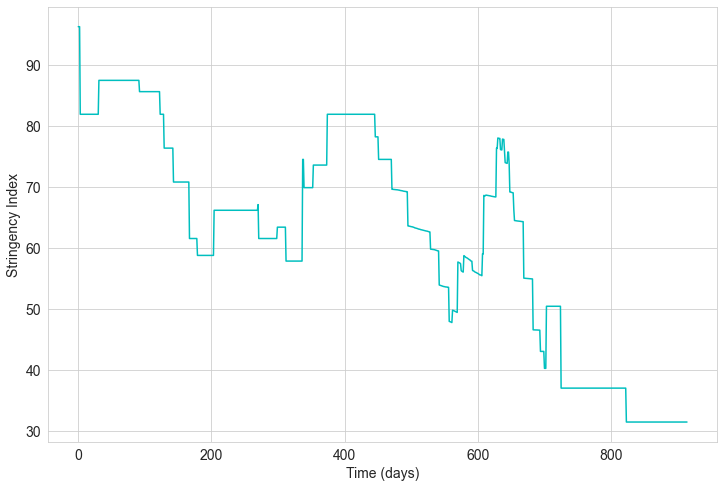

In [23]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu]
lockdown = list(df['stringency_index'].values / 100)
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N, lockdown),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma, optimal_nu = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma} optimal_nu: {optimal_nu}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, optimal_nu, lockdown))
S, I, R = ret.T

plt.figure(figsize=(12, 8))
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time (days)')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIRV_model_with_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(t, df['stringency_index'], 'c')
plt.xlabel('Time (days)')
plt.ylabel('Stringency Index')
plt.grid(True)

SIRV_with_lockdown_cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost: {SIRV_with_lockdown_cost}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


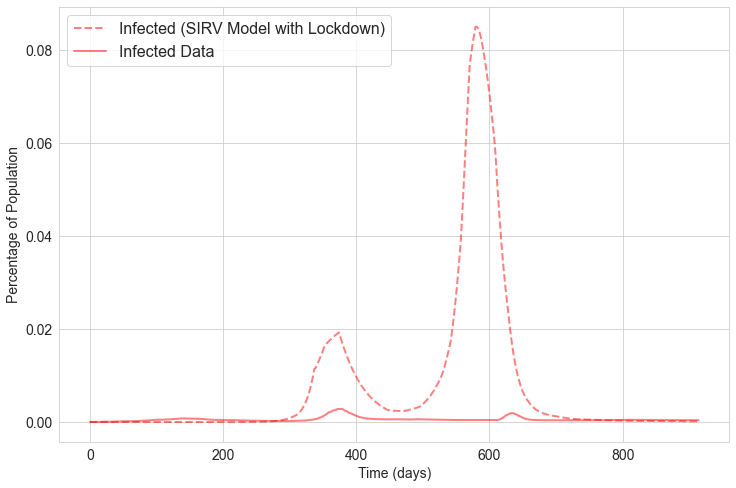

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (SIRV Model with Lockdown)')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.xlabel('Time (days)')
plt.ylabel('Percentage of Population')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "SIRV_model_with_lockdown_infections_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

In [25]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_with_lockdown_with_vaccination"] = S
df["I_modelled_with_lockdown_with_vaccination"] = I
df["R_modelled_with_lockdown_with_vaccination"] = R
df["r_eff_modelled_with_lockdown_with_vaccination"] = r0 * df["S_modelled_with_lockdown_with_vaccination"]/N
df["r_eff_actual_with_lockdown_with_vaccination"] = r0 * df["S"]/df["N"]

In [26]:
optimal_values = {
    'optimal_beta': optimal_beta,
    'optimal_gamma': optimal_gamma,
    'optimal_nu': optimal_nu
}

with open(OPTIMAL_VALUES_FILE, "w") as outfile: 
    json.dump(optimal_values, outfile)

## Vaccination dependent on Time

In [27]:
window_length = 30

def deriv(y, t, N, nu, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -optimal_beta * (1 - lockdown[int(t)]) * S * I / N - nu * S
    dIdt = optimal_beta * (1 - lockdown[int(t)]) * S * I / N - optimal_gamma * I
    dRdt = optimal_gamma * I + nu * S
#     print(dSdt, dIdt, dRdt)
    return dSdt[0], dIdt, dRdt[0]

def integrate_system(params, y0, t, N, lockdown):
    nu = params
    result = odeint(deriv, y0, t, args=(N, nu, lockdown), hmax=1.0)
    return result

def objective_function(params, y0, t, N, lockdown, days_window):
    predictions = integrate_system(params, y0, t, N, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'][days_window-window_length:days_window], S) + 
            compute_cost(df['I'][days_window-window_length:days_window], I) + 
            compute_cost(df['R'][days_window-window_length:days_window], R))
    return cost

In [28]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.2, 1./10, 0.001

In [29]:
nu_changing_with_time = []
time_points_for_nu = []
for days_window in range(window_length, days_difference, window_length):
    lockdown = list(df['stringency_index'].values / 100)[days_window - 10:days_window]
    t = np.linspace(days_window - window_length, days_window, window_length)
    initial_guesses = [initial_guess_for_nu]
    result = minimize(
        objective_function,
        initial_guesses,
        args=(y0, t, N, lockdown, days_window),
        method='Nelder-Mead',
    )
    optimal_nu = result.x
    print(f"optimal_nu: {optimal_nu}")
    if optimal_nu < 0.0:
        optimal_nu = [0.0]
    nu_changing_with_time.append(optimal_nu[0])
    time_points_for_nu.append(days_window - window_length)
    N = df.loc[min(df.index), ['N']].item()
    y0 = df.loc[days_window, ['S']].item(), df.loc[days_window, ['I']].item(), df.loc[days_window, ['R']].item()
    initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.2, 1./10, 0.001

optimal_nu: [5.31387329e-07]
optimal_nu: [1.88922882e-06]
optimal_nu: [7.06691742e-06]
optimal_nu: [1.36090994e-05]
optimal_nu: [-2.60208521e-18]
optimal_nu: [-0.00014937]
optimal_nu: [-4.80617821e-05]
optimal_nu: [-4.38164234e-05]
optimal_nu: [-3.7234962e-05]
optimal_nu: [-2.82060683e-05]
optimal_nu: [0.00010161]
optimal_nu: [0.00026411]
optimal_nu: [0.00075722]
optimal_nu: [0.00030839]
optimal_nu: [0.00097931]
optimal_nu: [0.00101154]
optimal_nu: [0.00189643]
optimal_nu: [0.00242359]
optimal_nu: [0.00299081]
optimal_nu: [0.00575796]
optimal_nu: [0.00520524]
optimal_nu: [0.00530691]
optimal_nu: [0.00327532]
optimal_nu: [0.00162533]
optimal_nu: [0.00238081]
optimal_nu: [0.00177364]
optimal_nu: [0.00166276]
optimal_nu: [0.00103042]
optimal_nu: [0.00058738]
optimal_nu: [0.00020327]


## SIRV model with time varying nu

In [30]:
days_difference

914

In [31]:
print(nu_changing_with_time, time_points_for_nu)

[5.31387329098962e-07, 1.8892288207981841e-06, 7.06691741943101e-06, 1.3609099388119992e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010160987973212961, 0.00026410877704620173, 0.0007572182357311241, 0.00030838561654090703, 0.0009793132722377776, 0.0010115400016307832, 0.0018964295625686677, 0.002423590558767324, 0.0029908135414123604, 0.00575796226263048, 0.005205242139101044, 0.005306909418106097, 0.003275317049026498, 0.0016253277897834793, 0.002380809247493749, 0.0017736434102058438, 0.0016627565026283279, 0.0010304233431816102, 0.0005873757183551778, 0.00020326981544494416] [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870]


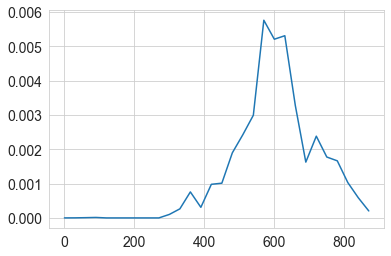

In [32]:
plt.plot(time_points_for_nu, nu_changing_with_time)

In [33]:
new_time_points = np.arange(0, 915, 1)  # Adjust the range and step size as needed

# Interpolate nu_changing_with_time to match the new time points
interpolated_nu = np.interp(new_time_points, time_points_for_nu, nu_changing_with_time)

# Print the interpolated nu array and its length
print(len(interpolated_nu))

915


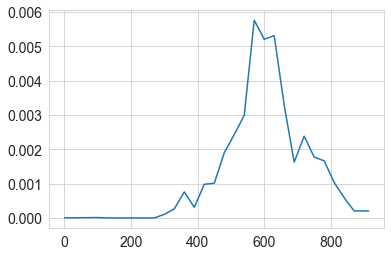

In [34]:
plt.plot(new_time_points, interpolated_nu)

In [35]:
df['nu_varying_with_time'] = interpolated_nu

In [36]:
def deriv(y, t, N, beta, gamma, nu_varying, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N - nu_varying[int(t)] * S
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I + nu_varying[int(t)] * S
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N, nu_varying, lockdown):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, nu_varying, lockdown))
    return result

def objective_function(params, y0, t, N, nu_varying, lockdown):
    predictions = integrate_system(params, y0, t, N, nu_varying, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [37]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

In [ ]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
lockdown = list(df['stringency_index'].values / 100)
nu_varying = list(df['nu_varying_with_time'].values)
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N, nu_varying, lockdown),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, nu_varying, lockdown))
S, I, R = ret.T

plt.figure(figsize=(12, 8))
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time (days)')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIRV_model_with_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(t, df['stringency_index'], 'c')
plt.xlabel('Time (days)')
plt.ylabel('Stringency Index')
plt.grid(True)

SIRV_with_lockdown_cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost: {SIRV_with_lockdown_cost}")

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (SIRV Model with Lockdown)')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.xlabel('Time (days)')
plt.ylabel('Percentage of Population')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "SIRV_model_with_lockdown_infections_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

In [ ]:
breakcode

## Comparing costs

In [ ]:
print(SIR_cost - SIRV_with_lockdown_cost)
print(SIR_with_lockdown_cost - SIRV_with_lockdown_cost)

In [ ]:
stringency_data_points = np.arange(0, 100, 0.5)
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
predicted_gdp = fit_line_loaded(stringency_data_points)
MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)

In [ ]:
df['gdp_min_max_normalized'] = (df['gdp_normalized'] - MIN_GDP) / (MAX_GDP - MIN_GDP)
df['gdp_normalized_modelled_min_max_normalized'] =  (df['gdp_normalized_modelled'] - MIN_GDP) / (MAX_GDP - MIN_GDP)

In [ ]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))

In [ ]:
df.diff()['stringency_index'][1:].describe()

In [ ]:
df['stringency_index'].describe()

In [ ]:
actions_taken = []
# "output/actions_taken/-14154.05.txt"
with open("output/actions_taken/-209965.53.txt", "r") as f:
    for line in f:
        actions_taken.append(int(line.strip()))
start_stringency = 0.0
current_stringency_index = start_stringency
stringency_index_from_actions_taken = [current_stringency_index]
# stringency_index_from_actions_taken = []
diff_list = []
for action in actions_taken:
    reward_inertia_flag = False
    if action == 0:
        current_stringency_index = max(0, current_stringency_index - 10)
        diff = -10
    elif action == 1:
        current_stringency_index = max(0, current_stringency_index - 5)
        diff = -5
    elif action == 2:
        current_stringency_index = max(0, current_stringency_index - 2.5)
        diff = -2.5
    elif action == 3:
        current_stringency_index = max(0, current_stringency_index + 0)
        diff = 0
    elif action == 4:
        current_stringency_index = min(100, current_stringency_index + 2.5)
        diff = 2.5
    elif action == 5:
        current_stringency_index = min(100, current_stringency_index + 5)
        diff = 5
    elif action == 6:
        current_stringency_index = min(100, current_stringency_index + 10)
        diff = 10
    stringency_index_from_actions_taken.append(current_stringency_index)
    diff_list.append(diff)

# stringency_index_from_actions_taken = stringency_index_from_actions_taken + [0]
stringency_index_from_actions_taken = np.array(stringency_index_from_actions_taken)
stringency_index_from_actions_taken = stringency_index_from_actions_taken[:916]
# the below is a checking mechanism
# stringency_index_from_actions_taken = np.array([0] + list(df['stringency_index']))

In [ ]:
def calculate_reward_weighted(gdp_min_max_normalized_list, r_eff_list):
    GDP_WEIGHT_1 = 10 # change this value and see how it affects the reward
    GDP_WEIGHT_2 = 20 # change this value and see how it affects the reward
    reward = []
    for i in range(len(gdp_min_max_normalized_list)):
        if r_eff_list[i] > 1.9:
            reward.append(-20 * r_eff_list[i])
        elif r_eff_list[i] <= 1.9 and r_eff_list[i] >= 1.5:
            reward.append(GDP_WEIGHT_1 * gdp_min_max_normalized_list[i])
        else:
            reward.append(GDP_WEIGHT_2 * gdp_min_max_normalized_list[i])
    return reward

In [ ]:
def reward_strategy(stringency_moves, reward_strategy_choosen, sir_technique):   
    N = df.loc[min(df.index), ['N']].item()
    y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
    days_difference = (max(df['date']) - min(df['date'])).days
    t = np.linspace(0, days_difference, days_difference + 1)
    
    stringency_index_random_choice = []
    store_S = np.zeros(days_difference + 1)
    store_I = np.zeros(days_difference + 1)
    store_R = np.zeros(days_difference + 1)

    # sir_technique 1 is faster
    # 2 is just to check whether the results match with 1
    moves_lockdown = stringency_index_from_actions_taken / 100
    if sir_technique == 1:
        moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, optimal_nu, moves_lockdown))
        moves_S, moves_I, moves_R = moves_ret.T

        df["S_moves"] = moves_S
        df["I_moves"] = moves_I
        df["R_moves"] = moves_R
    elif sir_technique == 2:
        for ith_day in range(days_difference + 1):
            stringency_index_random_choice.append(stringency_index_from_actions_taken[ith_day])
            t = np.linspace(0, ith_day, ith_day + 1)
            moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, optimal_nu, np.array(stringency_index_random_choice) / 100))
            moves_S, moves_I, moves_R = moves_ret.T
            store_S[ith_day] = moves_S[-1]
            store_I[ith_day] = moves_I[-1]
            store_R[ith_day] = moves_R[-1]
        df["S_moves"] = store_S
        df["I_moves"] = store_I
        df["R_moves"] = store_R
    
    df["r_eff_moves_with_lockdown_with_vaccination"] = r0 * df["S_moves"] / N
    df["gdp_normalized_moves_min_max_normalized"] = ((fit_line_loaded(stringency_index_from_actions_taken) - MIN_GDP) / (MAX_GDP - MIN_GDP))[1:]
    
    modelled_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, optimal_nu, (df['stringency_index']) / 100))
    modelled_S, modelled_I, modelled_R = modelled_ret.T
    
    df["S_modelled_with_lockdown_with_vaccination_with_vaccination_with_vaccination_inside_plot"] = modelled_S
    df["I_modelled_with_lockdown_with_vaccination_with_vaccination_inside_plot"] = modelled_I
    df["R_modelled_with_lockdown_with_vaccination_inside_plot"] = modelled_R
    
    plt.figure(figsize=(10, 6))
    plt.plot(df["S_modelled_with_lockdown_with_vaccination_with_vaccination_with_vaccination_inside_plot"], color='b', label='S_modelled')
    plt.plot(df["I_modelled_with_lockdown_with_vaccination_with_vaccination_inside_plot"], color='r', label='I_modelled')
    plt.plot(df["R_modelled_with_lockdown_with_vaccination_inside_plot"], color='g', label='R_modelled')
    plt.plot(df["S_moves"], 'b--', label='S_moves')
    plt.plot(df["I_moves"], 'r--', label='I_moves')
    plt.plot(df["R_moves"], 'g--', label='R_moves')
    plt.xlabel('days')
    plt.ylabel('Population')
    plt.title('SIR_dynamics')
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['stringency_index'], color='b', label='actual')
    plt.plot(stringency_index_from_actions_taken , color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('stringency')
    plt.title('stringency')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['r_eff_actual_with_lockdown_with_vaccination'], color='b', label='actual')
    plt.plot(df['r_eff_modelled_with_lockdown_with_vaccination'], color='r', label='modelled')
    plt.plot(df['r_eff_moves_with_lockdown_with_vaccination'], color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('r_eff')
    plt.title('R_eff')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df['gdp_min_max_normalized'], color='b', label='actual')
    plt.plot(df['gdp_normalized_modelled_min_max_normalized'], color='r', label='modelled')
    plt.plot(df['gdp_normalized_moves_min_max_normalized'], color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('gdp')
    plt.title('GDP')
    plt.legend()
    plt.show()
        
    if reward_strategy_choosen == 1:
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown_with_vaccination"], color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown_with_vaccination'])))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown_with_vaccination"], color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown_with_vaccination'])))
        plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown_with_vaccination"], color='g', label='reward(modelled) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown_with_vaccination"])))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown_with_vaccination"], color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown_with_vaccination'])))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown_with_vaccination"], color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown_with_vaccination'])))
        # plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"], color='g', label='reward(modelled) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"])))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
    if reward_strategy_choosen == 2:
        plt.figure(figsize=(10, 6))
        
        index_to_the_power_of = 0.001
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown_with_vaccination"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown_with_vaccination'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown_with_vaccination"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown_with_vaccination'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown_with_vaccination"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='g', label='reward(moves) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown_with_vaccination"] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown_with_vaccination"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown_with_vaccination'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown_with_vaccination"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown_with_vaccination'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        # plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='g', label='reward(moves) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
    if reward_strategy_choosen == 3:
        
        # we need the epidemic to happen and also the I population to stay below a certain value (beds in the hospital) (10 multiple)
        # we need r_eff to be below 1 at an earlier stage (1 multiple)
        # we need to reward inertia by a small amount (0.1 multiple)
        
        hospital_capacity = 0.082
        hospital_capacity_reward = -5000
        # reward_I_percentage = -100 if self.I_proportion >= 0.082 else 0
        I_reward_actual = [hospital_capacity_reward if I_percentage >= hospital_capacity else 0 for I_percentage in df["I"] / df["N"]]
        I_reward_modelled = [hospital_capacity_reward if I_percentage >= hospital_capacity else 0 for I_percentage in df["I_modelled_with_lockdown_with_vaccination"] / N]
        I_reward_moves = [hospital_capacity_reward if I_percentage >= hospital_capacity else 0 for I_percentage in df["I_moves"] / N]
        
        r_eff_reward_choosen = 1
        r_eff_punishment_choosen = -1
        r_eff_level = 1.9
        r_eff_reward_actual = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_actual_with_lockdown_with_vaccination"]]
        r_eff_reward_modelled = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_modelled_with_lockdown_with_vaccination"]]
        r_eff_reward_moves = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_moves_with_lockdown_with_vaccination"]]
        
        inertia_rewards_actual = [0] + [abs(diff)*2*-1 for diff in (df['stringency_index'][i] - df['stringency_index'][i - 1] for i in range(1, len(df)))]
        # modelled reward for intertia is same as actual
        inertia_rewards_modelled = [0] + [abs(diff)*2*-1 for diff in (df['stringency_index'][i] - df['stringency_index'][i - 1] for i in range(1, len(df)))]
        inertia_rewards_moves = [abs(diff)*2*-1 for diff in (stringency_index_from_actions_taken[i] - stringency_index_from_actions_taken[i - 1] for i in range(1, len(stringency_index_from_actions_taken)))]
        
        # index_to_the_power_of = 0.00001
        # reward_actual = (df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_actual + r_eff_reward_actual + inertia_rewards_actual
        # reward_modelled = (df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_modelled + r_eff_reward_modelled + inertia_rewards_modelled
        # reward_moves = (df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_moves + r_eff_reward_moves + inertia_rewards_moves
        
        # TODO try this...
        """
        def calculate_reward(gdp_normalized, r_eff_actual):
            GDP_WEIGHT = 0.35 # change this value and see how it affects the reward
            if r_eff_actual > 1:
                # When r_eff > 1, the reward is more heavily influenced by the reduction in r_eff
                return gdp_normalized / (5 * r_eff_actual)
            else:
                # When r_eff <= 1, the reward is more heavily influenced by the increase in GDP
                return GDP_WEIGHT * gdp_normalized
        """
        
        reward_actual = calculate_reward_weighted(df["gdp_min_max_normalized"], df["r_eff_actual_with_lockdown_with_vaccination"]) + I_reward_actual + r_eff_reward_actual + inertia_rewards_actual
        reward_modelled = calculate_reward_weighted(df["gdp_normalized_modelled_min_max_normalized"], df["r_eff_modelled_with_lockdown_with_vaccination"]) + I_reward_modelled + r_eff_reward_modelled + inertia_rewards_modelled
        reward_moves = calculate_reward_weighted(df["gdp_normalized_moves_min_max_normalized"], df["r_eff_moves_with_lockdown_with_vaccination"]) + I_reward_moves + r_eff_reward_moves + inertia_rewards_moves
        
        rl_reward_moves = reward_moves
        rl_reward_weighted = calculate_reward_weighted(df["gdp_normalized_moves_min_max_normalized"], df["r_eff_moves_with_lockdown_with_vaccination"])
        rl_reward_I_percentage = I_reward_moves
        rl_reward_r_eff = r_eff_reward_moves
        rl_reward_inertia = inertia_rewards_moves

        plt.plot(reward_actual, color='b', label='reward(actual) = {reward}'.format(reward = np.sum(reward_actual)))
        plt.plot(reward_modelled, color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(reward_modelled)))
        plt.plot(reward_moves, color='g', label='reward(moves) = {reward}'.format(reward = np.sum(reward_moves)))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        return rl_reward_moves, rl_reward_weighted, rl_reward_I_percentage, rl_reward_r_eff, rl_reward_inertia

In [ ]:
rl_reward_moves, rl_reward_weighted, rl_reward_I_percentage, rl_reward_r_eff, rl_reward_inertia = reward_strategy(stringency_index_from_actions_taken, reward_strategy_choosen=3, sir_technique=1)